# Configuración del Entorno de Trabajo con PyTorch y Manipulación de Datos

Este código importa las bibliotecas necesarias para la construcción y entrenamiento de un modelo deep learning utilizando PyTorch. Se incluyen librerías para manipulación de datos (NumPy, sklearn), definición de redes neuronales (torch.nn), manejo de datasets (torchvision), y optimización de parámetros (torch.optim). Se define además el dispositivo utilizado para el modelo, priorizando la tarjeta gráfica (GPU) si está disponible.

In [1]:
#Importar las bibliotecas necesarias

import torch
from  torch import optim 
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset, DataLoader

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Preparación del Conjunto de Datos y DataLoader:

Este código define un conjunto de datos de imágenes de Hatha Yoga Suave, y lo divide en conjuntos de entrenamiento y prueba. El conjunto de entrenamiento se utiliza para entrenar un modelo de clasificación de imágenes, y el conjunto de prueba se utiliza para evaluar el rendimiento del modelo.

In [2]:
# Ruta a tu directorio con la estructura de carpetas existente
data_dir = '../../Datasets/Hatha-Yoga-Suave/'

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Cargar el dataset directamente desde la estructura de carpetas
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes

# Dividir los índices de las imágenes en conjuntos de entrenamiento, validación y prueba
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Primero, dividir en entrenamiento y temporal (validación + prueba)
train_indices, temp_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=(val_size + test_size)
)

# Luego, dividir el conjunto temporal en validación y prueba
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=test_size / (val_size + test_size)
)

# Crear subsets (conjuntos) de entrenamiento, validación y prueba basados en los índices obtenidos
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Crear DataLoader para iterar a través de los subsets (conjuntos)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Datos para Entrenamiento: ", len(train_loader))
print("Datos para Validación: ", len(val_loader))
print("Datos para Prueba: ", len(test_loader))



Datos para Entrenamiento:  119
Datos para Validación:  26
Datos para Prueba:  26


## Visualización de Datos de Entrenamiento
Este código define una función para visualizar imágenes de un conjunto de datos de Hatha Yoga Suave. La función recibe un batch de imágenes y las muestra en una cuadrícula, junto con sus títulos.

In [3]:
# # Función para visualizar imágenes
# def imshow(inp, title=None):
#     """Display image for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.5, 0.5, 0.5])  # Normalización inversa: media
#     std = np.array([0.5, 0.5, 0.5])   # Normalización inversa: desviación estándar
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)

# # Obtener un batch de datos de entrenamiento
# inputs, classes = next(iter(train_loader))

# # Crear una cuadrícula a partir del batch
# out = torchvision.utils.make_grid(inputs)

# # Mostrar la cuadrícula de imágenes usando la función imshow
# class_names = full_dataset.classes
# imshow(out, title=[class_names[x] for x in classes])
# plt.axis('off')  # Apagar ejes para una visualización más limpia
# plt.show()

# Adaptación de Modelo Preentrenado para Clasificación
Este código descarga el modelo preentrenado DenseNet121, lo congela para evitar que se actualice, y reemplaza el clasificador por uno personalizado con 9 clases.

In [4]:
# Descargar el modelo preentrenado DenseNet121
model = models.densenet121(pretrained=True)

# Congelar los parámetros del modelo preentrenado
for param in model.parameters():
    param.requires_grad = False

# Obtener el número de características de la última capa antes del clasificador
num_features = model.classifier.in_features

# Reemplazar el clasificador por uno personalizado para tu número de clases (4 en este caso)
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 9)
)


# Mover el modelo a la GPU si está disponible
model = model.to(device)
model


/home/eutimio/Documentos/9no Ciclo/TIC/DESARROLLO/CRISP-ML/Entrenamiento/env_training/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eutimio/Documentos/9no Ciclo/TIC/DESARROLLO/CRISP-ML/Entrenamiento/env_training/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Entrenamiento, Validación y Selección del Mejor Modelo


Este código entrena el modelo preentrenado con 9 clases. Durante el entrenamiento, calcula la pérdida y la precisión para el conjunto de entrenamiento y el conjunto de validación. También guarda el mejor modelo basado en la precisión de validación.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(),lr=0.001)

# Listas para guardar la pérdida y precisión
train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []

# Mejor precisión de validación
best_val_accuracy = 0

# Entrenar el modelo
for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    
    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy.append(correct / total)
    
    print(f'Época {epoch+1}: Pérdida de Entrenamiento: {epoch_loss:.4f}, Precisión de Entrenamiento: {epoch_accuracy:.4f} | Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {correct / total:.4f}')
    
    # Guardar el mejor modelo
    if correct / total > best_val_accuracy:
        best_val_accuracy = correct / total
        torch.save(model.state_dict(), './modelos/DN121_v4.pth')


Época 1: Pérdida de Entrenamiento: 1.0774, Precisión de Entrenamiento: 0.7196 | Pérdida de Validación: 0.5914, Precisión de Validación: 0.8864
Época 2: Pérdida de Entrenamiento: 0.4529, Precisión de Entrenamiento: 0.9333 | Pérdida de Validación: 0.3818, Precisión de Validación: 0.9333
Época 3: Pérdida de Entrenamiento: 0.2946, Precisión de Entrenamiento: 0.9540 | Pérdida de Validación: 0.3071, Precisión de Validación: 0.9358
Época 4: Pérdida de Entrenamiento: 0.2147, Precisión de Entrenamiento: 0.9646 | Pérdida de Validación: 0.2717, Precisión de Validación: 0.9407
Época 5: Pérdida de Entrenamiento: 0.1593, Precisión de Entrenamiento: 0.9757 | Pérdida de Validación: 0.2464, Precisión de Validación: 0.9383
Época 6: Pérdida de Entrenamiento: 0.1435, Precisión de Entrenamiento: 0.9825 | Pérdida de Validación: 0.2017, Precisión de Validación: 0.9506
Época 7: Pérdida de Entrenamiento: 0.1183, Precisión de Entrenamiento: 0.9868 | Pérdida de Validación: 0.2155, Precisión de Validación: 0.9481

# Evaluación del modelo

El código genera un gráfico con dos subplots para visualizar la evolución del entrenamiento del modelo DenseNet121 con 9 clases. El subplot de la pérdida muestra que la pérdida de entrenamiento disminuye a lo largo de las épocas, mientras que la pérdida de validación se mantiene baja. El subplot de la precisión muestra que la precisión de entrenamiento aumenta a lo largo de las épocas, mientras que la precisión de validación se mantiene alta. Esto indica que el modelo se está aprendiendo bien y tiene un buen rendimiento.

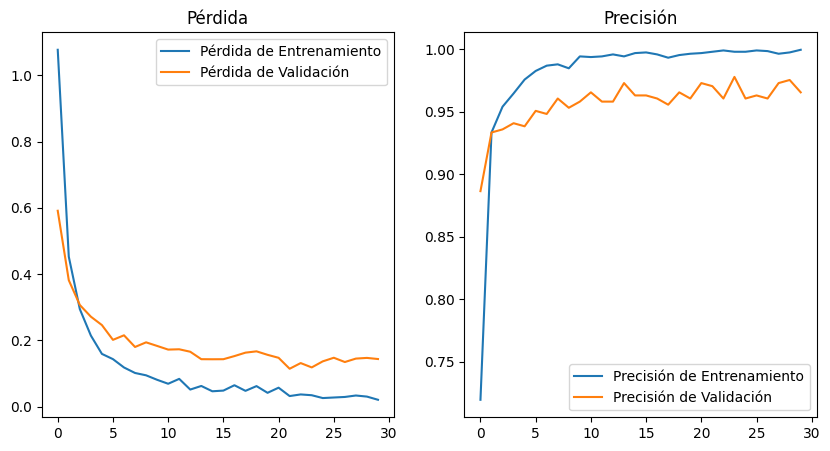

,Pérdida de Entrenamiento,Pérdida de Validación,Precisión de Entrenamiento,Precisión de Validación
0,1.077443,0.591445,0.719577,0.886420
1,0.452927,0.381816,0.933333,0.933333
2,0.294632,0.307050,0.953968,0.935802
3,0.214682,0.271709,0.964550,0.940741
4,0.159345,0.246363,0.975661,0.938272
5,0.143521,0.201731,0.982540,0.950617
6,0.118339,0.215469,0.986772,0.948148
7,0.101738,0.180240,0.987831,0.960494
8,0.094672,0.194225,0.984656,0.953086
9,0.081141,0.183389,0.994180,0.958025


In [6]:
plt.figure(figsize=(10, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.legend()
plt.title('Pérdida')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Precisión de Entrenamiento')
plt.plot(val_accuracy, label='Precisión de Validación')
plt.legend()
plt.title('Precisión')

plt.show()

# Crear un DataFrame para mostrar los valores en una tabla
data = {
    'Pérdida de Entrenamiento': train_losses,
    'Pérdida de Validación': val_losses,
    'Precisión de Entrenamiento': train_accuracy,
    'Precisión de Validación': val_accuracy
}
df = pd.DataFrame(data)

# Mostrar la tabla de valores
df

Se calculó la matriz de confusión utilizando la función confusion_matrix() de la biblioteca scikit-learn. A continuación, se creó una figura y un eje para la matriz de confusión. La matriz de confusión se representó utilizando la función matshow(), y se añadió una barra de colores para representar los valores de la matriz. Finalmente, se añadieron anotaciones a cada celda de la matriz de confusión, mostrando el número de observaciones que se encontraban en cada celda.

/home/eutimio/Documentos/9no Ciclo/TIC/DESARROLLO/CRISP-ML/Entrenamiento/env_training/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eutimio/Documentos/9no Ciclo/TIC/DESARROLLO/CRISP-ML/Entrenamiento/env_training/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pérdida de Prueba: 0.1622, Precisión de Prueba: 0.9457


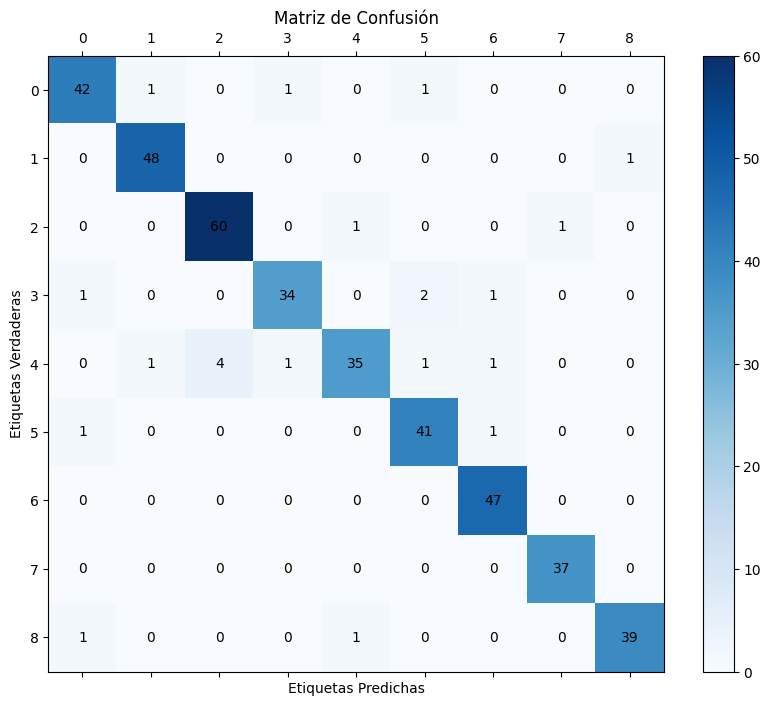

In [7]:
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 9)
)  # 9 clases
model.load_state_dict(torch.load('./modelos/DN121_v4.pth'))
model = model.to(device)

# Evaluar el modelo
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Pérdida de Prueba: {test_loss:.4f}, Precisión de Prueba: {test_accuracy:.4f}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Añadir etiquetas a los ejes
classes = np.arange(9)  # Asumiendo que hay 9 clases
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

# Añadir valores a los cuadros
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()